In [1]:
!pip install python-dotenv langchain serpapi  --quiet
!pip install langchain_openai langgraph langchain_core langchain_community --quiet
!apt-get install graphviz libgraphviz-dev --quiet
!pip install pygraphviz --quiet
!pip install serpapi --quiet

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import sys

# Get the current working directory
current_directory = os.getcwd()

# Print the absolute path
print(f"Current working directory: {current_directory}")

# Absolute path of the flight module
notebook_path = os.path.join(current_directory, 'flight_handler.py')
print(f"Absolute path of the notebook: {notebook_path}")

# Add the directory containing flight_handler.py to the Python path
sys.path.append(os.path.dirname(notebook_path))

# Check if the file exists
if os.path.exists(notebook_path):
  print(f"File {notebook_path} exists")
else:
  print(f"File {notebook_path} does not exist")

# List the files in the current directory
# !ls -l


Current working directory: /content
Absolute path of the notebook: /content/flight_handler.py
File /content/flight_handler.py exists


In [4]:
# Absolute path of the hotel module
notebook_path = os.path.join(current_directory, 'hotel_handler.py')
print(f"Absolute path of the notebook: {notebook_path}")

# Add the directory containing hotel_handler.py to the Python path
sys.path.append(os.path.dirname(notebook_path))

# Check if the file exists
if os.path.exists(notebook_path):
  print(f"File {notebook_path} exists")
else:
  print(f"File {notebook_path} does not exist")

# List the files in the current directory
# !ls -l

Absolute path of the notebook: /content/hotel_handler.py
File /content/hotel_handler.py exists


In [5]:
import hotel_handler
import flight_handler
import json
from langchain import hub
from langchain.agents import create_openai_tools_agent
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from IPython.display import Image

In [6]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Instanciate the Flights, Hotels and Events modules.

In [7]:
flight_tool = flight_handler.Flights()
hotel_tool = hotel_handler.Hotels()

In [8]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

# TravelAgent class: LLM agentic workflow

In [9]:
class TravelAgent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        # print(message)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        print(tool_calls)
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                # result = self.tools[t['name']].invoke(input=t['args'])
                input_params = {
                    'query': query_parameters,
                }
                result = self.tools[t['name']].invoke(input=input_params)
            # print(result)
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        print(results)
        return {'messages': results}



# Flight parameters to pull tickets

In [10]:
query_parameters = {
        'origin': 'ATL',
        'destination': 'JFK',
        'departure_date': '2024-07-27',
        'return_date': '2024-07-30',
        'currency': 'USD'
        }

# System Prompt to Instruct, LLM, Tools, Graph, and Draw

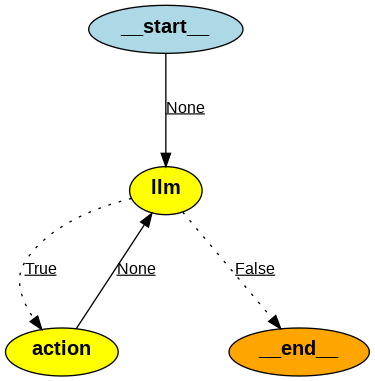

In [11]:
# event_tool = Events()

prompt = """You are a smart travel agency assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information (tickets, hotels, events) when you are sure of what you want. \
Generate plan to process tickets, hotels and events. For events, provide information and questions based on destination only.\
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo", api_key=OPENAI_API_KEY)  #reduce inference cost

tool = [flight_tool, hotel_tool,]

abot = TravelAgent(model, tool, system=prompt)

Image(abot.graph.get_graph().draw_png())


In [12]:
# Assuming `query_parameters` is defined elsewhere in your code
# query_parameters = {
#     'origin': 'ATL',
#     'destination': 'JFK',
#     'departure_date': '2024-07-30',
#     'return_date': '2024-08-05',
#     'currency': 'USD'
# }

# Create the message
messages = [HumanMessage(content="I need to travel to New York City")]

# Combine all parameters into a single dictionary
input_params = {
    'query': query_parameters,
    'messages': messages
}

# Pass the combined parameters to the invoke method of the Flights tool
result = abot.graph.invoke(input=input_params)

# Print the result
# print(result)


[{'name': 'flights_tool', 'args': {}, 'id': 'call_DOE4V5WmvFSTyqZ22UkeUYhU', 'type': 'tool_call'}]
Calling: {'name': 'flights_tool', 'args': {}, 'id': 'call_DOE4V5WmvFSTyqZ22UkeUYhU', 'type': 'tool_call'}
Back to the model!
[ToolMessage(content="{'Departure': 'ATL', 'Arrival': 'JFK', 'flight_details': [{'airlines': ['Delta'], 'layover': 'NA', 'Duration': 163, 'price': 377}, {'airlines': ['Delta'], 'layover': 'NA', 'Duration': 169, 'price': 377}, {'airlines': ['Delta'], 'layover': 'NA', 'Duration': 154, 'price': 377}, {'airlines': ['American', 'American'], 'layover': [{'duration': 102, 'name': 'Charlotte Douglas International Airport', 'id': 'CLT'}], 'Duration': 300, 'price': 396}, {'airlines': ['JetBlue'], 'layover': 'NA', 'Duration': 149, 'price': 442}, {'airlines': ['American', 'American'], 'layover': [{'duration': 70, 'name': 'Charlotte Douglas International Airport', 'id': 'CLT'}], 'Duration': 279, 'price': 582}]}", name='flights_tool', tool_call_id='call_DOE4V5WmvFSTyqZ22UkeUYhU')

In [13]:
print(result['messages'][-1].content)



I found some flight options for your trip to New York City (JFK Airport) from Atlanta (ATL Airport):

1. Delta Airlines
   - Duration: 2 hours and 43 minutes
   - Price: $377

2. Delta Airlines
   - Duration: 2 hours and 49 minutes
   - Price: $377

3. Delta Airlines
   - Duration: 2 hours and 34 minutes
   - Price: $377

4. American Airlines (with layover at Charlotte Douglas International Airport)
   - Duration: 5 hours
   - Price: $396

5. JetBlue Airlines
   - Duration: 2 hours and 29 minutes
   - Price: $442

6. American Airlines (with layover at Charlotte Douglas International Airport)
   - Duration: 4 hours and 39 minutes
   - Price: $582

Do you want to proceed with booking any of these flights?


In [14]:
messages = [HumanMessage(content="I would like a hotel reservation in New York City")]
query_parameters = {
        'q': 'New York',
        'check_in_date': '2024-07-27',
        'check_out_date': '2024-07-30',
        'currency': 'USD'
    }

input_params = {
    'query': query_parameters,
    'messages': messages
}

result = abot.graph.invoke(input=input_params)

[{'name': 'hotels_tool', 'args': {}, 'id': 'call_tEeuGzh1IrujsESqoUViv47D', 'type': 'tool_call'}]
Calling: {'name': 'hotels_tool', 'args': {}, 'id': 'call_tEeuGzh1IrujsESqoUViv47D', 'type': 'tool_call'}
Back to the model!
[ToolMessage(content="{'Destination': 'New York', 'hotel_details': [{'property_name': 'Accor Live Limitless', 'rate_per_night': 'N/A', 'rating': 'N/A'}, {'property_name': 'Best Western International', 'rate_per_night': 'N/A', 'rating': 'N/A'}, {'property_name': 'Choice Hotels', 'rate_per_night': 'N/A', 'rating': 'N/A'}, {'property_name': 'Extended Stay America', 'rate_per_night': 'N/A', 'rating': 'N/A'}, {'property_name': 'Four Seasons', 'rate_per_night': 'N/A', 'rating': 'N/A'}, {'property_name': 'Hilton Honors', 'rate_per_night': 'N/A', 'rating': 'N/A'}, {'property_name': 'Hyatt', 'rate_per_night': 'N/A', 'rating': 'N/A'}, {'property_name': 'IHG Hotels & Resorts', 'rate_per_night': 'N/A', 'rating': 'N/A'}, {'property_name': 'Knights Inn', 'rate_per_night': 'N/A', 'r

In [15]:
print(result['messages'][-1].content)

I have found several hotel options in New York City for you:

1. Accor Live Limitless
2. Best Western International
3. Choice Hotels
4. Extended Stay America
5. Four Seasons
6. Hilton Honors
7. Hyatt
8. IHG Hotels & Resorts
9. Knights Inn
10. Marriott Bonvoy
11. Melia Hotels International
12. NH Hotel Group
13. Omni Hotels & Resorts
14. OYO
15. Radisson Hotel Group
16. Red Roof Inn
17. RIU Hotels & Resorts
18. Westgate Resorts
19. Wyndham Hotels & Resorts

Please let me know if you would like more information or assistance with booking any of these hotels.


## End